In [1]:
import pandas as pd
import math as m
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import  metrics
from itertools import product
from datetime import datetime, date, time
import calendar
%pylab inline

C:\Users\kisma\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


C:\Users\kisma\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
data = pd.read_csv('trade_data.csv')

In [4]:
#Обработаем время
#Create by Asim
from datetime import datetime, date, time
k = 0
data['DAY'] = 0
data['MONTH'] = 0
date = []
for i in data.DATE:
    d = datetime.strptime(i,'%d.%m.%y')
    date.append(d)
    data.loc[k,'DAY'] = datetime.isoweekday(d)
    data.loc[k,'MONTH'] = d.month
    k = k + 1
data.index = date
data.drop('DATE', axis =1, inplace=True)
data.head()

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES,DAY,MONTH
2017-07-24,9.11,9.15,8.50,8.55,8.97,NaN,2325011000,37,1,7
2017-07-25,9.09,9.10,8.81,8.81,9.02,NaN,3477388000,31,2,7
2017-07-26,9.06,9.35,9.05,9.10,9.15,NaN,6537394000,36,3,7
2017-07-27,9.17,9.40,9.17,9.25,9.30,NaN,3387899000,26,4,7
2017-07-28,9.31,9.32,9.20,9.20,9.26,NaN,4659405000,31,5,7


In [6]:
data.shape

(153, 10)

In [7]:
#добавим target
target = []
target.append(1)#просто так как он первый ----?-----
for i in range(1, len(data)):
    if data.WAP[i] > data.WAP[i-1]:
        target.append(1)
    else:
        target.append(0)
data['target'] = target
data.head(10)

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES,DAY,MONTH,target
2017-07-24,9.11,9.15,8.50,8.55,8.97,NaN,2325011000,37,1,7,1
2017-07-25,9.09,9.10,8.81,8.81,9.02,NaN,3477388000,31,2,7,1
2017-07-26,9.06,9.35,9.05,9.10,9.15,NaN,6537394000,36,3,7,1
2017-07-27,9.17,9.40,9.17,9.25,9.30,NaN,3387899000,26,4,7,1
2017-07-28,9.31,9.32,9.20,9.20,9.26,NaN,4659405000,31,5,7,0
2017-07-31,9.30,9.30,9.10,9.11,9.21,NaN,5181650000,26,1,7,0
2017-08-01,9.23,9.26,9.14,9.14,9.19,NaN,4002500000,30,2,8,0
2017-08-02,9.14,9.14,9.05,9.05,9.09,NaN,5745400000,27,3,8,0
2017-08-03,9.08,9.08,8.65,8.65,8.98,NaN,5598335000,52,4,8,0
2017-08-04,8.90,9.01,7.55,7.60,8.44,NaN,4233004060,39,5,8,0


Удалим Выброс

In [8]:
data = pd.concat([data[:'2017-12-27'],data['2018-01-10':] ], axis = 0)

In [9]:
data.shape

(148, 11)

In [10]:
data['WAP'].std()

0.5979742877072248

In [151]:
data.to_csv('AHAN_TRAIN')

(array([72.,  0., 73.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

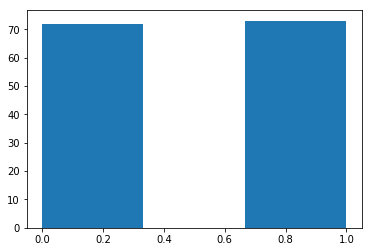

In [13]:
plt.hist(log_data.target, bins=3)

## Сгенерируем новые данные

#### ЛАГИ

In [7]:
#Функция на вход получает DataFrame с панельными данными
#Возвращает DataFrame с лагами
def time_series_to_DataFrame(data, lags, target):
    lags = list(map(lambda x: x+1, lags))
    #Готовим название колонок
    columns = []
    for i in range(len(data.columns)):
        #print (i , lags[i])
        for j in range(1, lags[i]):
            #print ('i = ', i,'j = ',j)
            #print (columns)
            columns.append(data.columns[i] + '_lag_' + str(j))
    columns.append(target)
    #готовим target
    target = pd.DataFrame(data[target].values[max(lags)-1:])
    #готовим индексы
    index = data.index
    
    
    data = data.values
    
    new_data = []
    for i in range(max(lags)-1,len(data)):
        res = []
        for lag in range(len(lags)):
            for j in range(1,lags[lag]):
                res.append(data[i-j][lag])
        new_data.append(res)
    
    
    new_data = pd.DataFrame(new_data)
    new_data = pd.concat([new_data, target], axis = 1)
    new_data.columns = columns
    new_data.index = index[max(lags)-1:]
    return new_data

### Процентное изменение

In [14]:
def percent_change(data, lag, target, percent = None):
    lag += 1
    new_data = []
    new_DataFrame = pd.DataFrame()
    new_DataFrame[target] = data[target][lag:]
    new_DataFrame.index = data.index[lag:]
    for i in range( lag ,len(data)):
        res = []
        for j in range(1,lag):
            if percent == True:
                res.append(data[target][i-j]/data[target][i-j-1] * 100 - 100)
            else:
                res.append(data[target][i-j]/data[target][i-j-1])
        new_data.append(res)
    import numpy as np
    new_data = np.array(new_data)
    new_data = new_data.transpose()
    for i in range(1, lag):
        new_DataFrame[target + '_percent_change_' + str(i)] = new_data[i-1]
    new_DataFrame.drop(target, axis = 1, inplace=True)
    return new_DataFrame

In [15]:
def percent_change_DataFrame(data, list_of_percent_change, percent = None):
    shape = []
    for i in list_of_percent_change:
        shape.append(i[1])
    shape = max(shape)
    shape = len(data) - shape - 1
    
    data_percent_change = pd.DataFrame()
    data_percent_change['target'] = data.target[-shape:]
    data_percent_change.index = data.index[-shape:]
    
    for i in list_of_percent_change:
        DataFrame = percent_change(data, i[1], i[0], percent)
        data_percent_change = pd.concat([data_percent_change, DataFrame[-shape:]], axis = 1 )
    data_percent_change.drop('target', axis = 1, inplace=True)
    return data_percent_change

### скользящие среднее

In [16]:
def moving_average(data, lag, target):
    averege = []
    new_DataFrame = pd.DataFrame()
    for i in range(lag,len(data[target])):
        sum_ = 0
        for j in range(1, lag + 1):
            sum_ += data[target][i - j]
        averege.append(sum_/(lag))
    new_DataFrame[target + '_averege_' + str(lag)] = averege
    new_DataFrame.index = data.index[lag:]
    return new_DataFrame

In [17]:
def moving_average_DataFrame(data, list_of_moving_average):
    shape = []
    for i in list_of_moving_average:
        shape.append(i[1])
    shape = max(shape)
    shape = len(data) - shape
    
    data_moving_average = pd.DataFrame()
    data_moving_average['target'] = data.target[-shape:]
    data_moving_average.index = data.index[-shape:]
    
    for i in list_of_moving_average:
        DataFrame = moving_average(data, i[1], i[0])
        data_moving_average = pd.concat([data_moving_average, DataFrame[-shape:]], axis = 1 )
    data_moving_average.drop('target', axis = 1, inplace=True)
    return data_moving_average

### Скользящие среднее геометрическое

In [18]:
def moving_average_geom(data, lag, target, percent = None):
    lag += 1
    
    new_data = []
    for i in range( lag ,len(data)):
        res = 1
        for j in range(1,lag):
            res *= (data[target][i-j]/data[target][i-j-1])
        res = res ** (1/(lag - 1))
        if percent == True:
            res = res *100 - 100
        new_data.append(res)
    
    new_DataFrame = pd.DataFrame()
    new_DataFrame[target + 'average_geom' + str(lag-1)] = new_data
    new_DataFrame.index = data.index[lag:]
    
    return new_DataFrame

In [19]:
moving_average_geom(data, 3, "WAP", True).head()

,WAPaverage_geom3
2017-07-28,1.211572
2017-07-31,0.879166
2017-08-01,0.218103
2017-08-02,-0.395830
2017-08-03,-0.615735


### Количество подряд идущих

In [20]:
def consecutive(data,target):
    consecutive_0 = [0]
    consecutive_1 = [0]
    for i in range(1, len(data)):
        j = 1
        consecutive_0.append(0)
        consecutive_1.append(0)
        while i - j >= 0 and data[target][i-j] == 1:
            consecutive_1[i] += 1
            j += 1 
        j = 1
        while i - j >= 0 and data[target][i-j] == 0:
            consecutive_0[i] += 1
            j += 1
    
    data_new = pd.DataFrame()
    data_new[target + '_consecutive_0'] = consecutive_0
    data_new[target + '_consecutive_1'] = consecutive_1
    data_new.index = data.index
    return data_new

In [21]:
consecutive(data, 'target').head()

,target_consecutive_0,target_consecutive_1
2017-07-24,0,0
2017-07-25,0,1
2017-07-26,0,2
2017-07-27,0,3
2017-07-28,0,4


In [22]:
#Для удобства работы, таргет последняя колонка
def target_to_end(data, target):
    col_target = data[target]
    data.drop(target, axis = 1, inplace=True)
    data[target] = col_target
    return data

Теперь переменные стоит отмаштобировать

In [24]:
#на вход подается данные и список столбцов, которые надо отмаштобировать
def scaling_for_DataFrame(X_train, X_test, columns_to_scaling):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train[columns_to_scaling])
    
    X_train_1 = scaler.transform(X_train[columns_to_scaling])
    X_test_1 = scaler.transform( X_test[columns_to_scaling])
    
    X_train_1 = np.array(X_train_1)
    X_test_1 = np.array(X_test_1)
    
    X_train_1 = X_train_1.transpose()
    X_test_1 = X_test_1.transpose()
    
    for i in range(len(X_train_1)):
        X_train[columns_to_scaling[i]] = X_train_1[i]
        X_test[columns_to_scaling[i]] = X_test_1[i]
    return X_train, X_test

### Кодирование Средним

In [28]:
#Рассмотрим распределение по дням
data.groupby('DAY').mean()

,OPEN,HIGH,LOW,CLOSE,WAP,VALUE,NUMTRADES,MONTH,target
DAY,,,,,,,,,
1,8.152414,8.311034,7.679655,7.761724,8.087931,2.862664e+10,128.724138,7.724138,0.551724
2,8.140333,8.251667,7.503667,7.589667,8.081000,2.901237e+10,133.333333,7.866667,0.566667
3,8.112258,8.240645,7.449677,7.682903,8.020968,3.092647e+10,140.580645,7.677419,0.419355
4,8.106667,8.302333,7.752000,7.848667,8.085333,2.815941e+10,136.200000,7.600000,0.666667
5,8.185000,8.263929,7.640357,7.738214,8.082500,2.631048e+10,126.714286,8.035714,0.357143


In [42]:
def silly_target_encoding(data, feature, target):
    import pandas as pd
    mean_target = data.groupby(feature).mean()[target]
    mean_encoding = []
    for i in data[feature]:
        mean_encoding.append(mean_target[i])
    DataFrame = pd.DataFrame()
    DataFrame[feature + '_silly_target_encoding' ] = mean_encoding## в data.DAY почему-то 149 записей??
    DataFrame.index = data.index
    return DataFrame

In [43]:
def time_series_target_encoding(data, feature, target, alfa):
    def mean_reg_encoding(global_mean, mean, count, alfa):
        return (mean*count + global_mean*alfa)/(count+alfa)
    
    
    import pandas as pd
    global_mean = len(data[data.target == 1]) / len(data)
    target_encoding = []
    for i in range(len(data)):
        try:
            feature_value = data[feature][i]
            mean = data[:i].groupby(feature).mean()[target][feature_value]
            count = data[:i].groupby(feature).count()[target][feature_value]
            mean_reg = mean_reg_encoding(global_mean = global_mean, mean= mean, count=count, alfa= alfa)
            target_encoding.append(mean_reg)
        except:
            mean = global_mean
            target_encoding.append(mean)
    DataFrame = pd.DataFrame()
    DataFrame[feature + '_target_encoding' ] = target_encoding
    DataFrame.index = data.index
    return DataFrame

### Дополнительные данные

### НЕФТЬ

In [44]:
neft = pd.read_csv('neft-wti_quotes.csv', sep=';')
neft = neft[::-1]# переворачиваем
neft.index = neft.updated # индекс - время
neft = neft[str(data.index[0]):str(data.index[-1])].average
neft_price = []
for i in range(len(neft)):
    if neft.index[i] in data.index:
        neft_price.append(neft[i])
data['petroleum_prise'] = neft_price
data.head()

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES,DAY,MONTH,target,petroleum_prise,exchange_rate
2017-07-24,9.11,9.15,8.50,8.55,8.97,NaN,2325011000,37,1,7,1,46.050,69.7390
2017-07-25,9.09,9.10,8.81,8.81,9.02,NaN,3477388000,31,2,7,1,47.565,69.6750
2017-07-26,9.06,9.35,9.05,9.10,9.15,NaN,6537394000,36,3,7,1,48.365,69.6431
2017-07-27,9.17,9.40,9.17,9.25,9.30,NaN,3387899000,26,4,7,1,48.745,69.3320
2017-07-28,9.31,9.32,9.20,9.20,9.26,NaN,4659405000,31,5,7,0,49.345,69.8995


### Валютный курс

In [45]:
exchange_rate = pd.read_csv('EURRUB.csv')
#Преобразовать дату
from datetime import datetime, date, time
date = []
for i in exchange_rate['<DATE>']:
    d = datetime.strptime(i,'%d/%m/%y')
    date.append(d)
    k = k + 1
exchange_rate.index = date
exchange_rate = exchange_rate['<CLOSE>']
exchange_rate_column = []
for i in range(len(exchange_rate)):
    if exchange_rate.index[i] in data.index:
        exchange_rate_column.append(exchange_rate[i])
data['exchange_rate'] = exchange_rate_column
data.head()

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES,DAY,MONTH,target,petroleum_prise,exchange_rate
2017-07-24,9.11,9.15,8.50,8.55,8.97,NaN,2325011000,37,1,7,1,46.050,69.7390
2017-07-25,9.09,9.10,8.81,8.81,9.02,NaN,3477388000,31,2,7,1,47.565,69.6750
2017-07-26,9.06,9.35,9.05,9.10,9.15,NaN,6537394000,36,3,7,1,48.365,69.6431
2017-07-27,9.17,9.40,9.17,9.25,9.30,NaN,3387899000,26,4,7,1,48.745,69.3320
2017-07-28,9.31,9.32,9.20,9.20,9.26,NaN,4659405000,31,5,7,0,49.345,69.8995


____________________________

# Попробуем что-то обучить

### Выдернем нужные данные

##### лаги

In [46]:
data.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'WAP', 'LTTIME', 'VALUE', 'NUMTRADES',
       'DAY', 'MONTH', 'target', 'petroleum_prise', 'exchange_rate'],
      dtype='object')

In [47]:
lags = [0,0,0,0,5,0,3,2,0,0,5,3,3]

In [48]:
lag_data = time_series_to_DataFrame(data, lags, 'target')
lag_data.drop('target', axis =  1, inplace= True)
lag_data.head()

,WAP_lag_1,WAP_lag_2,WAP_lag_3,WAP_lag_4,WAP_lag_5,VALUE_lag_1,VALUE_lag_2,VALUE_lag_3,NUMTRADES_lag_1,NUMTRADES_lag_2,...,target_lag_2,target_lag_3,target_lag_4,target_lag_5,petroleum_prise_lag_1,petroleum_prise_lag_2,petroleum_prise_lag_3,exchange_rate_lag_1,exchange_rate_lag_2,exchange_rate_lag_3
2017-07-31,9.26,9.30,9.15,9.02,8.97,4659405000,3387899000,6537394000,31,26,...,1,1,1,1,49.345,48.745,48.365,69.8995,69.3320,69.6431
2017-08-01,9.21,9.26,9.30,9.15,9.02,5181650000,4659405000,3387899000,26,31,...,0,1,1,1,49.795,49.345,48.745,70.6895,69.8995,69.3320
2017-08-02,9.19,9.21,9.26,9.30,9.15,4002500000,5181650000,4659405000,30,26,...,0,0,1,1,49.400,49.795,49.345,71.1855,70.6895,69.8995
2017-08-03,9.09,9.19,9.21,9.26,9.30,5745400000,4002500000,5181650000,27,30,...,0,0,0,1,49.100,49.400,49.795,71.6540,71.1855,70.6895
2017-08-04,8.98,9.09,9.19,9.21,9.26,5598335000,5745400000,4002500000,52,27,...,0,0,0,0,49.370,49.100,49.400,71.5410,71.6540,71.1855


#### процентное изменение

In [49]:
percent_change_data = percent_change_DataFrame(data, [['WAP',4], ['VALUE', 3], ['petroleum_prise', 3],['exchange_rate', 3]], True)
percent_change_data.head()

,WAP_percent_change_1,WAP_percent_change_2,WAP_percent_change_3,WAP_percent_change_4,VALUE_percent_change_1,VALUE_percent_change_2,VALUE_percent_change_3,petroleum_prise_percent_change_1,petroleum_prise_percent_change_2,petroleum_prise_percent_change_3,exchange_rate_percent_change_1,exchange_rate_percent_change_2,exchange_rate_percent_change_3
2017-07-31,-0.430108,1.639344,1.441242,0.557414,37.530812,-48.176613,87.997255,1.230895,0.785692,1.681909,0.818525,-0.446706,-0.045784
2017-08-01,-0.539957,-0.430108,1.639344,1.441242,11.208405,37.530812,-48.176613,0.911946,1.230895,0.785692,1.130194,0.818525,-0.446706
2017-08-02,-0.217155,-0.539957,-0.430108,1.639344,-22.756265,11.208405,37.530812,-0.793252,0.911946,1.230895,0.701660,1.130194,0.818525
2017-08-03,-1.088139,-0.217155,-0.539957,-0.430108,43.545284,-22.756265,11.208405,-0.607287,-0.793252,0.911946,0.658140,0.701660,1.130194
2017-08-04,-1.210121,-1.088139,-0.217155,-0.539957,-2.559700,43.545284,-22.756265,0.549898,-0.607287,-0.793252,-0.157702,0.658140,0.701660


#### Скользящие среднее

In [50]:
moving_average_data = moving_average_DataFrame(data,  [['WAP', 3], ['target', 6]])
moving_average_data.head()

,WAP_averege_3,target_averege_6
2017-08-01,9.256667,0.666667
2017-08-02,9.220000,0.500000
2017-08-03,9.163333,0.333333
2017-08-04,9.086667,0.166667
2017-08-07,8.836667,0.000000


#### скользящие среднее геометрическое

In [51]:
moving_average_geom_data = moving_average_geom(data, 5, "WAP", True)
moving_average_geom_data.head()

,WAPaverage_geom5
2017-08-01,0.529480
2017-08-02,0.374130
2017-08-03,-0.131493
2017-08-04,-0.697844
2017-08-07,-1.837346


### Количество подряд идущих нулей и единиц

In [52]:
consecutive_data = consecutive(data,'target')
consecutive_data.head()

,target_consecutive_0,target_consecutive_1
2017-07-24,0,0
2017-07-25,0,1
2017-07-26,0,2
2017-07-27,0,3
2017-07-28,0,4


#### target encoding

In [53]:
target_encoding_data = time_series_target_encoding(data, 'DAY', 'target', alfa = 3)
target_encoding_data.head()

,DAY_target_encoding
2017-07-24,0.513514
2017-07-25,0.513514
2017-07-26,0.513514
2017-07-27,0.513514
2017-07-28,0.513514


#### silly_target_encoding

In [54]:
silly_target_encoding_data = silly_target_encoding(data, 'DAY', 'target')
silly_target_encoding_data.head()

,DAY_silly_target_encoding
2017-07-24,0.551724
2017-07-25,0.566667
2017-07-26,0.419355
2017-07-27,0.666667
2017-07-28,0.357143


##### Выделим те , которые надо отмаштобировать

In [55]:
columns_for_scaling = []# их надо будет отмаштобировать
for i in lag_data.columns:
    columns_for_scaling.append(i)
columns_for_scaling.append('WAP_averege_3')

## Соединим все данные

In [56]:
ready_data = data[['target', 'DAY']]
list_of_DataFtame = [ready_data, lag_data, percent_change_data, moving_average_data,
                     moving_average_geom_data,consecutive_data,target_encoding_data ]

In [57]:
#соединяем DataFrame
def concat_DataFrame(list_of_DataFtame, axis):
    import pandas as pd
    shape = []
    for i in list_of_DataFtame:
        shape.append(len(i))
    shape = min(shape)
    list_of_DataFtame = map(lambda x: x[-shape:], list_of_DataFtame)
    ready_data = pd.concat(list_of_DataFtame, axis = axis)
    return ready_data

In [58]:
ready_data = concat_DataFrame(list_of_DataFtame, 1)
ready_data.head()

,target,DAY,WAP_lag_1,WAP_lag_2,WAP_lag_3,WAP_lag_4,WAP_lag_5,VALUE_lag_1,VALUE_lag_2,VALUE_lag_3,...,petroleum_prise_percent_change_3,exchange_rate_percent_change_1,exchange_rate_percent_change_2,exchange_rate_percent_change_3,WAP_averege_3,target_averege_6,WAPaverage_geom5,target_consecutive_0,target_consecutive_1,DAY_target_encoding
2017-08-01,0,2,9.21,9.26,9.30,9.15,9.02,5181650000,4659405000,3387899000,...,0.785692,1.130194,0.818525,-0.446706,9.256667,0.666667,0.529480,2,0,0.635135
2017-08-02,0,3,9.19,9.21,9.26,9.30,9.15,4002500000,5181650000,4659405000,...,1.230895,0.701660,1.130194,0.818525,9.220000,0.500000,0.374130,3,0,0.635135
2017-08-03,0,4,9.09,9.19,9.21,9.26,9.30,5745400000,4002500000,5181650000,...,0.911946,0.658140,0.701660,1.130194,9.163333,0.333333,-0.131493,4,0,0.635135
2017-08-04,0,5,8.98,9.09,9.19,9.21,9.26,5598335000,5745400000,4002500000,...,-0.793252,-0.157702,0.658140,0.701660,9.086667,0.166667,-0.697844,5,0,0.385135
2017-08-07,0,1,8.44,8.98,9.09,9.19,9.21,4233004060,5598335000,5745400000,...,-0.607287,-1.395284,-0.157702,0.658140,8.836667,0.000000,-1.837346,6,0,0.508108


#### делим на обучение и тест

In [59]:
X_train = ready_data[ready_data.columns[1:]][:110]
Y_train = ready_data['target'][:110]
X_test = ready_data[ready_data.columns[1:]][110:]
Y_test = ready_data['target'][110:]

In [60]:
#Маштабируем пирзнаки
X_train, X_test = scaling_for_DataFrame(X_train, X_test, columns_for_scaling)

In [61]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)
predict = model.predict(X_test)
print ('качество на test = ', metrics.accuracy_score(Y_test.values, predict))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.53125
качество на train =  0.7636363636363637


In [62]:
from sklearn.ensemble import RandomForestClassifier
forest_accuracy = []
for i in range(100):
    forest = RandomForestClassifier()
    forest.fit(X_train, Y_train)
    predict = forest.predict(X_test)
    #print (predict)
    #print (Y_test.values)
    forest_accuracy.append( metrics.accuracy_score(Y_test.values, predict) )
forest_accuracy = np.array(forest_accuracy)
print ('Качество на test = ',forest_accuracy.mean())

Качество на test =  0.535


In [63]:
from sklearn.ensemble import RandomForestClassifier
forest_accuracy = []
for i in range(100):
    forest = RandomForestClassifier()
    forest.fit(X_train, Y_train)
    predict = forest.predict(X_train)
    #print (predict)
    #print (Y_test.values)
    forest_accuracy.append( metrics.accuracy_score(Y_train.values, predict) )
forest_accuracy = np.array(forest_accuracy)
print ('Качество на train = ', forest_accuracy.mean())

Качество на train =  0.9845454545454544


Мы переобучились(

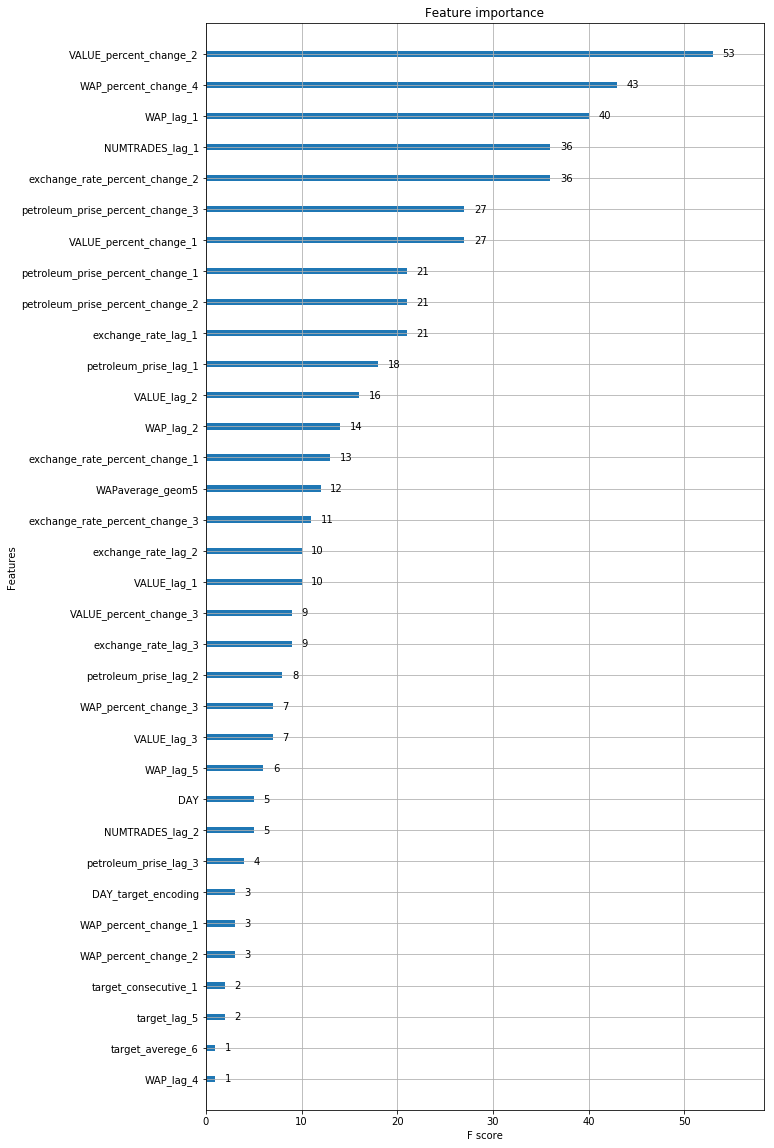

In [71]:
from xgboost import XGBClassifier
%matplotlib inline
def my_plot_importance(booster, figsize, **kwargs):
    from xgboost import plot_importance
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

model = XGBClassifier()
model.fit(X_train , Y_train)
impotant_of_cat = my_plot_importance(model , (10,20))

In [74]:
#Опять переобучились
print ('качество на test = ', metrics.accuracy_score(Y_test.values, model.predict(X_test)))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.59375
качество на train =  0.7


In [75]:
from sklearn.neighbors import KNeighborsClassifier as KNN
model = KNN()
model.fit(X_train,Y_train)
predict = model.predict(X_test)
print ('качество на test = ', metrics.accuracy_score(Y_test.values, predict))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.59375
качество на train =  0.7


In [67]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,Y_train)
predict = model.predict(X_test)
print ('качество на test = ', metrics.accuracy_score(Y_test.values, predict))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.46875
качество на train =  1.0


In [68]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train,Y_train)
predict = model.predict(X_test)
print ('качество на test = ', metrics.accuracy_score(Y_test.values, predict))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.53125
качество на train =  1.0


In [69]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,Y_train)
predict = model.predict(X_test)
print ('качество на test = ', metrics.accuracy_score(Y_test.values, predict))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.5
качество на train =  0.990909090909091


In [70]:
import lightgbm as lgbm

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'application': 'multiclass',
    'metric': 'acc',
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'objective': 'cross_entropy',
    'learning_rate': 0.01,
    'min_child_weight': 50,
    'max_depth': 5,  
}

model = lgbm.sklearn.LGBMClassifier(n_estimators=800, random_state=42, **params)
model.fit(X_train,Y_train)
predict = model.predict(X_test)
print ('качество на test = ', metrics.accuracy_score(Y_test.values, predict))
print('качество на train = ', metrics.accuracy_score(Y_train.values, model.predict(X_train)))

качество на test =  0.53125
качество на train =  0.4818181818181818


/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


_______________________

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

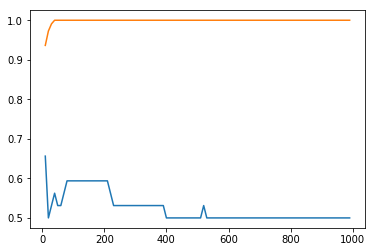

In [107]:
from xgboost import XGBClassifier
accuracy_test = []
accuracy_train = []
for i in range(10, 1000, 10):
    model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=i)
    model.fit(X_train , Y_train)
    accuracy_test.append(metrics.accuracy_score(Y_test.values, model.predict(X_test)))
    accuracy_train.append(metrics.accuracy_score(Y_train.values, model.predict(X_train)))
plt.plot(range(10, 1000, 10),accuracy_test )
plt.plot(range(10, 1000, 10),accuracy_train )

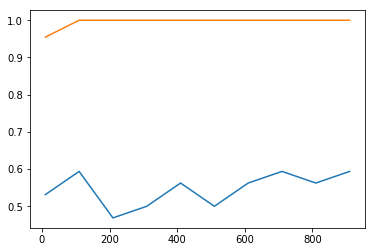

In [113]:
from sklearn.ensemble import RandomForestClassifier
accuracy_test = []
accuracy_train = []
for i in range(10, 1000, 100):
    model = RandomForestClassifier(n_estimators=i)
    model.fit(X_train , Y_train)
    accuracy_test.append(metrics.accuracy_score(Y_test.values, model.predict(X_test)))
    accuracy_train.append(metrics.accuracy_score(Y_train.values, model.predict(X_train)))
plt.plot(range(10, 1000, 100),accuracy_test )
plt.plot(range(10, 1000, 100),accuracy_train )

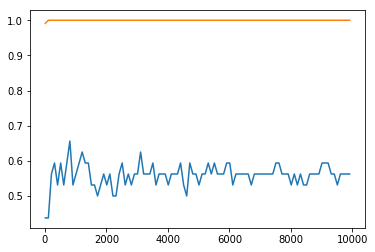

In [111]:
plt.plot(range(10, 10000, 100),accuracy_test )
plt.plot(range(10, 10000, 100),accuracy_train )

_________________

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/vladimir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

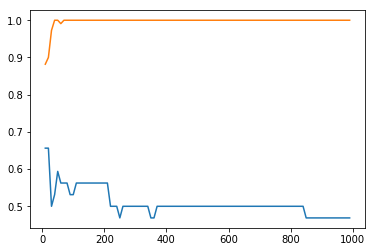

In [115]:
from xgboost import XGBClassifier
accuracy_test = []
accuracy_train = []
for i in range(10, 1000, 10):
    model = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=i)
    model.fit(X_train , Y_train)
    accuracy_test.append(metrics.accuracy_score(Y_test.values, model.predict(X_test)))
    accuracy_train.append(metrics.accuracy_score(Y_train.values, model.predict(X_train)))
plt.plot(range(10, 1000, 10),accuracy_test )
plt.plot(range(10, 1000, 10),accuracy_train )

___________________________________

_____________________________________

In [152]:
data_for_final = pd.read_csv('Dannye_dlya_finala .csv', sep=',')

In [153]:
from datetime import datetime, date, time
k = 0
data_for_final['DAY'] = 0
data_for_final['MONTH'] = 0
date = []
for i in data_for_final.DATE:
    d = datetime.strptime(i,'%d.%m.%y')
    date.append(d)
    data_for_final.loc[k,'DAY'] = datetime.isoweekday(d)
    data_for_final.loc[k,'MONTH'] = d.month
    k = k + 1
data_for_final.index = date
data_for_final.drop('DATE', axis =1, inplace=True)
data_for_final.head()

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES,DAY,MONTH
2018-03-02,7.40,7.46,6.50,6.50,7.35,NaN,66898067000,222,5,3
2018-03-05,7.15,7.40,6.95,6.95,7.32,NaN,72863878000,254,1,3
2018-03-06,7.30,7.41,6.00,6.00,7.31,NaN,67694221000,228,2,3
2018-03-07,7.40,7.60,1.00,7.35,7.18,NaN,49195974000,157,3,3
2018-03-09,7.30,7.40,7.30,7.30,7.35,NaN,2840840408,10,5,3


In [154]:
#добавим target
target = []
target.append(0)#просто проверил
for i in range(1, len(data_for_final)):
    if data_for_final.WAP[i] > data_for_final.WAP[i-1]:
        target.append(1)
    else:
        target.append(0)
data_for_final['target'] = target
data_for_final.head(10)

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES,DAY,MONTH,target
2018-03-02,7.40,7.46,6.50,6.50,7.35,NaN,66898067000,222,5,3,0
2018-03-05,7.15,7.40,6.95,6.95,7.32,NaN,72863878000,254,1,3,0
2018-03-06,7.30,7.41,6.00,6.00,7.31,NaN,67694221000,228,2,3,0
2018-03-07,7.40,7.60,1.00,7.35,7.18,NaN,49195974000,157,3,3,0
2018-03-09,7.30,7.40,7.30,7.30,7.35,NaN,2840840408,10,5,3,1
2018-03-12,7.30,7.45,6.52,6.55,7.35,NaN,46027847000,197,1,3,0
2018-03-13,7.35,7.45,6.95,6.95,7.38,NaN,55191938000,223,2,3,1
2018-03-14,7.35,7.52,7.35,7.42,7.42,NaN,92562140000,263,3,3,1
2018-03-15,7.40,7.45,6.00,6.78,7.37,NaN,69370455000,209,4,3,0
2018-03-16,7.40,7.44,6.85,6.85,7.33,NaN,71112491695,225,5,3,0


In [155]:
data_for_final.to_csv("AHAN_TEST")

Попробуем предсказать на 1 день и посмотреть что будет

In [129]:
# from xgboost import XGBClassifier
# X_train = ready_data[ready_data.columns[1:]][:110]
# Y_train = ready_data['target'][:110]
# X_test = ready_data[ready_data.columns[1:]][110:]
# Y_test = ready_data['target'][110:]